<a href="https://colab.research.google.com/github/p33ves/Starbucks-Passive-Customer-Detection/blob/main/DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mean Shift Model

In [ ]:
import pandas as pd
import numpy as np
import math

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.cluster import MeanShift
from sklearn.cluster import DBSCAN


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# !pip install plotly==4.12.0
import plotly.express as px

Loading dataset from Github repo

In [ ]:
full_dataset_url = "https://raw.githubusercontent.com/p33ves/CMPT726-ML-Project/main/processed_datasets/profile_features.csv"
data = pd.read_csv(full_dataset_url)
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 40 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   gender                              14825 non-null  object 
 1   age                                 14825 non-null  int64  
 2   cust_id                             14825 non-null  object 
 3   became_member_on                    14825 non-null  object 
 4   income                              14825 non-null  float64
 5   days_as_member                      14825 non-null  int64  
 6   Total offer completed               14825 non-null  float64
 7   Total offer received                14825 non-null  float64
 8   Total offer viewed                  14825 non-null  float64
 9   Total transaction                   14825 non-null  float64
 10  offer completed_via_email           14825 non-null  float64
 11  offer completed_via_social          14825

Extra Categories for clustering:

In [ ]:
#dropping columns that are not required for clustering
#select columns that are for clustering
data['bogo_comp_perc'] = data['offer completed bogo count'] / data['Total offer completed']
data['discount_comp_perc'] = data['offer completed discount count'] / data['Total offer completed']

data['bogo_view_perc'] = data['offer viewed bogo count'] / data['Total offer viewed']
data['discount_view_perc'] = data['offer viewed discount count'] / data['Total offer viewed']
data['info_view_perc'] = data['offer viewed informational count'] / data['Total offer viewed']

data['bogo_rec_perc'] = data['offer received bogo count'] / data['Total offer received']
data['discount_rec_perc'] = data['offer received discount count'] / data['Total offer received']
data['info_rec_perc'] = data['offer received informational count'] / data['Total offer received']

data['bogo_comp_ratio'] = data['offer completed bogo count'] / data['offer received bogo count']
data['discount_comp_ratio'] = data['offer completed discount count'] / data['offer received discount count']

data['bogo_view_ratio'] = data['offer viewed bogo count'] / data['offer received bogo count']
data['discount_view_ratio'] = data['offer viewed discount count'] / data['offer received discount count']
data['info_view_ratio'] = data['offer viewed informational count'] / data['offer received informational count']

data = data[['age','income', 'days_as_member', 
'Total offer completed', 'Total offer received','Total offer viewed',
'offer completed bogo count', 'offer completed discount count', 'offer received bogo count', 'offer received discount count', 'offer received informational count', 'offer viewed bogo count', 'offer viewed discount count', 'offer viewed informational count',
'bogo_comp_perc','discount_comp_perc', 'bogo_view_perc','discount_view_perc', 'info_view_perc',
'bogo_rec_perc','discount_rec_perc', 'info_rec_perc',
'bogo_comp_ratio','discount_comp_ratio','bogo_view_ratio','discount_view_ratio', 'info_view_ratio',
'avg_difficulty','avg_duration', 'total_reward_received', 'avg_transaction_amt','transactions_per_membership_days']]
data.sample(5)


,age,income,days_as_member,Total offer completed,Total offer received,Total offer viewed,offer completed bogo count,offer completed discount count,offer received bogo count,offer received discount count,offer received informational count,offer viewed bogo count,offer viewed discount count,offer viewed informational count,bogo_comp_perc,discount_comp_perc,bogo_view_perc,discount_view_perc,info_view_perc,bogo_rec_perc,discount_rec_perc,info_rec_perc,bogo_comp_ratio,discount_comp_ratio,bogo_view_ratio,discount_view_ratio,info_view_ratio,avg_difficulty,avg_duration,total_reward_received,avg_transaction_amt,transactions_per_membership_days
1209,64,36000.0,1069,3.0,6.0,4.0,2.0,1.0,3.0,2.0,1.0,2.0,1.0,1.0,0.666667,0.333333,0.500000,0.250000,0.25,0.500000,0.333333,0.166667,0.666667,0.5,0.666667,0.5,1.0,7.692308,169.846154,17.0,11.64,0.008419
14694,65,42000.0,944,3.0,4.0,4.0,2.0,1.0,2.0,2.0,0.0,2.0,2.0,0.0,0.666667,0.333333,0.500000,0.500000,0.00,0.500000,0.500000,0.000000,1.000000,0.5,1.000000,1.0,NaN,10.000000,200.727273,22.0,10.09,0.014831
747,31,55000.0,1522,2.0,4.0,2.0,2.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,1.000000,0.000000,1.000000,0.000000,0.00,0.500000,0.000000,0.500000,1.000000,NaN,1.000000,NaN,0.0,7.500000,150.000000,20.0,14.31,0.007884
5220,49,56000.0,1654,2.0,4.0,4.0,0.0,2.0,0.0,2.0,2.0,0.0,2.0,2.0,0.000000,1.000000,0.000000,0.500000,0.50,0.000000,0.500000,0.500000,NaN,1.0,NaN,1.0,1.0,6.000000,139.200000,4.0,14.40,0.007255
9714,65,76000.0,1885,6.0,6.0,6.0,4.0,2.0,4.0,2.0,0.0,4.0,2.0,0.0,0.666667,0.333333,0.666667,0.333333,0.00,0.666667,0.333333,0.000000,1.000000,1.0,1.000000,1.0,NaN,7.500000,160.000000,29.0,22.68,0.005836


In [ ]:
data['gender'].replace({'M':0, 'F':1,'O':2}, inplace=True)
data.head()

KeyError: ignored

In [ ]:
#Filling in avg_amount null values with Imputer
from sklearn.impute import SimpleImputer 

imputer = SimpleImputer(strategy = 'median')
data_imp = pd.DataFrame(imputer.fit_transform(data))

Adding label

In [ ]:
#data['customer_type'] = "passive"
#data.loc[(data['total_view_ratio'] >= 0.6) & (data['total_completion_ratio'] >= 0.2), 'customer_type'] = "active" 
#data['customer_type'].value_counts()

In [ ]:
#Standardscaler to scale the data
data_scaled = StandardScaler().fit_transform(data_imp)
data_scaled

array([[ 0.03488876,  2.15741893, -0.34943255, ..., -0.62221469,
         0.65169175, -1.03692356],
       [ 1.18543027,  1.60180089, -0.18960089, ...,  1.01514395,
         0.47484409, -0.19795577],
       [ 0.78274074,  0.2127558 , -1.02931353, ..., -0.40390021,
         0.2622635 , -0.82829701],
       ...,
       [-0.31027369,  0.35166031,  0.05611049, ..., -1.16800091,
        -0.60198861, -0.10798636],
       [ 1.64564687, -0.71327427,  0.83141336, ...,  1.56093017,
        -0.08234718,  0.57317696],
       [ 0.43757829,  0.76837384, -0.36613138, ..., -0.29474296,
         0.54085914, -0.33724304]])

In [ ]:
data_cluster = pd.DataFrame(data_scaled, columns = data.columns).dropna()
data_cluster.head()

,age,income,days_as_member,Total offer completed,Total offer received,Total offer viewed,offer completed bogo count,offer completed discount count,offer received bogo count,offer received discount count,offer received informational count,offer viewed bogo count,offer viewed discount count,offer viewed informational count,bogo_comp_perc,discount_comp_perc,bogo_view_perc,discount_view_perc,info_view_perc,bogo_rec_perc,discount_rec_perc,info_rec_perc,bogo_comp_ratio,discount_comp_ratio,bogo_view_ratio,discount_view_ratio,info_view_ratio,avg_difficulty,avg_duration,total_reward_received,avg_transaction_amt,transactions_per_membership_days
0,0.034889,2.157419,-0.349433,-0.742678,-2.313047,-2.604592,-0.017517,-1.050678,-0.707758,-1.591813,0.117481,-1.414305,-1.220437,-0.827778,1.674916,-1.674916,0.175555,-0.115927,-0.798382,0.417697,-1.663723,1.534467,1.020112,0.768385,-3.037058,0.735129,-2.287517,-1.819481,-0.539510,-0.622215,0.651692,-1.036924
1,1.185430,1.601801,-0.189601,0.534237,-0.451989,0.493128,1.871174,-1.050678,1.083996,-1.591813,0.117481,1.439781,-1.220437,0.483312,1.674916,-1.674916,1.021875,-1.284219,0.287776,1.458629,-1.663723,0.257448,1.020112,0.768385,0.521835,0.735129,0.514554,-0.958991,-0.791364,1.015144,0.474844,-0.197956
2,0.782741,0.212756,-1.029314,-0.104220,-0.451989,-0.281302,-0.017517,-0.132805,-0.707758,0.178261,0.117481,-0.462943,0.739693,-0.827778,0.096256,-0.096256,-0.388658,1.052365,-0.798382,-0.623234,0.412203,0.257448,1.020112,-0.438504,0.521835,0.735129,-2.287517,-0.241916,0.999599,-0.403900,0.262264,-0.828297
3,0.610160,-0.574370,-0.848012,1.811152,1.409069,2.041988,1.871174,0.785067,1.979873,0.178261,-1.024585,2.391143,0.739693,-0.827778,0.411988,-0.411988,0.739768,-0.115927,-0.798382,1.111652,-0.279773,-1.019571,0.413895,0.768385,0.521835,0.735129,0.514554,-0.427512,0.220991,0.905987,-0.167743,-0.895319
4,0.207470,-0.666973,-0.633313,-0.742678,-1.382518,-1.055732,-0.961863,-0.132805,-1.603635,0.178261,0.117481,-1.414305,0.739693,-0.827778,-1.482403,1.482403,-1.517085,2.220657,-0.798382,-1.664166,1.104178,0.683121,0.211823,-0.438504,0.521835,0.735129,-2.287517,-0.196843,1.307421,-0.949686,-0.666792,-0.707543


In [ ]:
x = [
      'income',
      'transactions_per_membership_days']

x1 = ['bogo_comp_ratio', 
      'transactions_per_membership_days']

x2 = ['discount_comp_ratio', 
      'transactions_per_membership_days']

x3 = ['age', 
      'transactions_per_membership_days']

x4 = ['days_as_member', 
      'transactions_per_membership_days']

X = data_cluster[x3].to_numpy()

In [ ]:
eps_range = [0.1, 0.3, 0.5, 0.7]
min_sample_range = [5,10,15]

for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit_predict(X)
        labels = model.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        print(str(eps), str(min_samples), str(n_clusters_), metrics.silhouette_score(X, labels), sep=',')

0.1,5,24,-0.16293796297581703
0.1,10,14,-0.2591268765098665
0.1,15,18,-0.34299154720385117
0.3,5,1,0.6202597618598507
0.3,10,1,0.5872588158793004
0.3,15,1,0.5546520909334156
0.5,5,1,0.6653258021225591
0.5,10,1,0.6427473639815912
0.5,15,1,0.6361879729764185
0.7,5,1,0.7133229209665584
0.7,10,1,0.7133229209665584
0.7,15,1,0.6979985832840595


Estimated number of clusters: 5


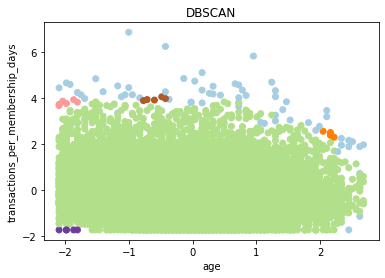

In [ ]:
# Plot result
import pylab as pl
from itertools import cycle

def dbscan(X, y, eps, min_samples):
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(X)
    y_pred = db.fit_predict(X)
    plt.scatter(X[:,0], X[:,1],c=y_pred, cmap='Paired')
    plt.title("DBSCAN")
    plt.xlabel(y[0])
    plt.ylabel(y[1])
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print('Estimated number of clusters: %d' % n_clusters_)
        
dbscan(X, x3, eps=.2, min_samples=5)